# LSB

* Using the LSB watermarking, embed the watermark in a bit that in neither the LSB nor the MSB. What happened? How this affect the results in terms of WPSNR?

* Embed the watermark and then attack your image before extracting the watermark. Can you still recover the watermark? if yes, when and how? Which attacks are the most effective? Which bit position guarantee more robustness? How does this affect the image quality?

### ERRATA CORRIGE. THE WATERMARKED IMAGE LOSE ITS QUALITY IF WE EMBED THE WATERMARK ON THE MOST SIGNIFICANT BIT AND IN ALL THE PIXELS

Image shape:  (512, 512)
Watermark:  [1 0 1 ... 1 1 0]


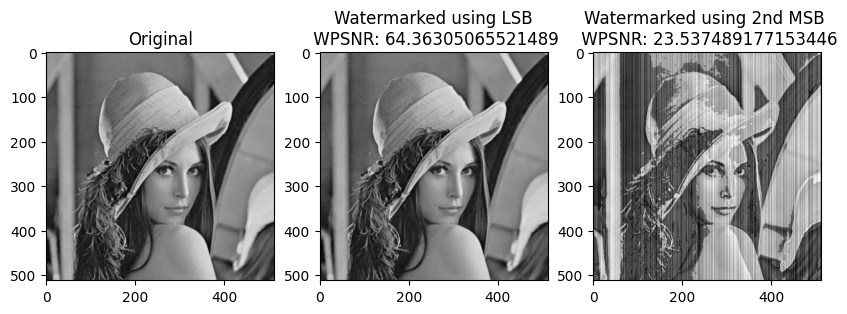

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt
plt.figure(figsize=(10, 10))



def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels


# Read image 
im = cv2.imread('lena_grey.bmp', 0)
# Check Image Shape
print('Image shape: ', np.shape(im))

#Genetate your watermark
N = 1024 #watermark size
watermark = (np.random.normal(0, 1, N) > 0).astype(int)
print('Watermark: ', watermark)

# Flatted the images for easy embedding in LSB
pixels_LSB = im.flatten()
flat_im_size = np.shape(pixels_LSB)

# Flatted the images for easy embedding in MSB
pixels_MSB = im.flatten()

# Embed in the Least Significant Bit ###########################

# Embedding
idx_watermark_bit = 0
for i in range(flat_im_size[0]):
  im_pixel_bytes = format(pixels_LSB[i], "08b")

  # concate all the pixels until the LSB from the image
  # and the MSB of the watermark as LSB
  watermarked_data = im_pixel_bytes[:7] + str(watermark[idx_watermark_bit])

  #encoding bytes back to pixels
  pixels_LSB[i] = int(watermarked_data, 2)
  idx_watermark_bit += 1
  if idx_watermark_bit > 1023:
     idx_watermark_bit = 0

################################################################

# Embed in MSB ####
idx_watermark_bit = 0
for i in range(flat_im_size[0]):
    im_pixel_bytes = format(pixels_MSB[i], "08b")

    # here we embed our watermark substituting its bits to the MSB
    watermarked_data = im_pixel_bytes[:1] + str(watermark[idx_watermark_bit]) + im_pixel_bytes[2:] 

  
    #encoding bytes back to pixels
    pixels_MSB[i] = int(watermarked_data, 2)
    idx_watermark_bit += 1
    if idx_watermark_bit > 1023:
        idx_watermark_bit = 0

################################################################


# Reshape image
watermarked_img_LSB = pixels_LSB.reshape(512, 512)
watermarked_img_MSB = pixels_MSB.reshape(512, 512)

#ESTIMATE WPSNR
wpsnr_LSB = wpsnr(im, watermarked_img_LSB)
wpsnr_MSB = wpsnr(im, watermarked_img_MSB)

# Show images side by side
plt.subplot(131)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.subplot(132)
plt.title('Watermarked using LSB\n WPSNR: ' + str(wpsnr_LSB) )
plt.imshow(watermarked_img_LSB,cmap='gray')
plt.subplot(133)
plt.title('Watermarked using 2nd MSB \n WPSNR: ' + str(wpsnr_MSB))
plt.imshow(watermarked_img_MSB,cmap='gray')
plt.show()



Threshold:  0.7083077811297267
Mark has been lost. SIM = 0.479532


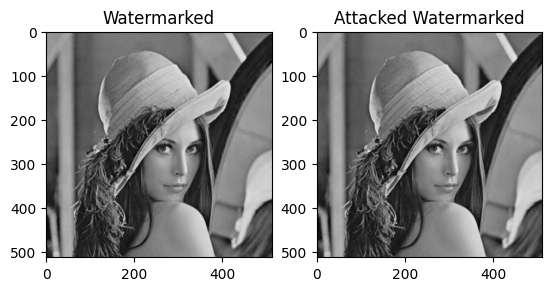

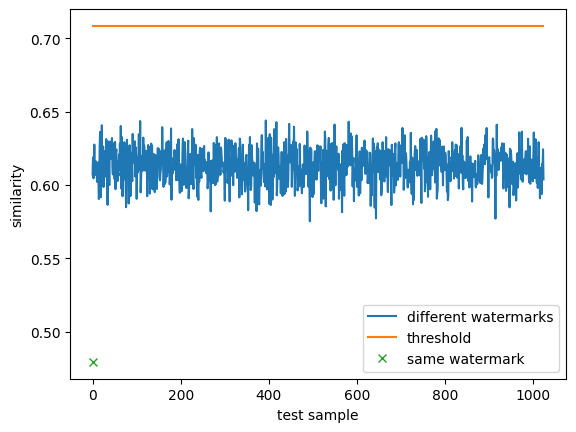

In [2]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

#apply attack 

attacked_watermarked_img_LSB = awgn(watermarked_img_LSB, 0.1, 123) #try change it with watermarked_img_MSB 

plt.subplot(121)
plt.title('Watermarked')
plt.imshow(watermarked_img_LSB, cmap='gray')
plt.subplot(122)
plt.title('Attacked Watermarked')
plt.imshow(attacked_watermarked_img_LSB,cmap='gray')

#DETECT THE WATERMARK

#move from a matrix to an array
watermarked = attacked_watermarked_img_LSB.flatten()
# Create empy flatten watermark array
extracted_watermarked = np.zeros(N)
for i in range(N):
  extracted_watermarked[i] = int(format(watermarked[i], "08b")[-1], 2) #[-1] locate the pixels LSB (i.e. the last position). If you embed the watermark in another position, change the value inside [] accordingly 


plt.figure()
sim = similarity(watermark, extracted_watermarked)
T, SIM_arr = compute_thr(sim, N, watermark, N)
plt.plot(SIM_arr, label='different watermarks')
plt.plot(np.ones(N)*T, label='threshold')
plt.plot(sim, 'x', label='same watermark')
plt.legend()
plt.ylabel('similarity')
plt.xlabel('test sample')

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

## Spread Spectrum:

1. Change the value of alpha

2. Compute the PSNR and WPSNR of watermarked images for 3 different values of alpha in the multiplicative version of the SS

3. Can you still detect the watermark if the image is attacked? Use different attack of Lab 1 to see how these affect the detection.

4. Play with the complete SS code (embedding + detection) and see what happens if you select different coefficients (e.g. low to mid frequencies).

5. Substitute the DCT with a transformation of your choice (wavelet or FFT). Which one works better? Does it improve of worse the results obtained using the DCT?

In [3]:
#1, 2 and 3

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

    return mark, watermarked

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alphas = [0.05, 0.1, 0.2]
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

for alpha in alphas:
    print('try alpha = ',alpha)
    mark, watermarked = embedding(image, N, alpha, v)
    #your attack
    attacked = awgn(watermarked, 15, 123)
    #detection
    w_ex = detection(image, watermarked, alpha, N, v)
    w_ex_att = detection(image, attacked, alpha, N, v)
    #wpsnr
    wspnr_watermarked = wpsnr(image, watermarked)
    wpsner_attacked = wpsnr(image, attacked)
    print('\n')
    print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
    print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
    #similarity
    sim_Attacked = similarity(w_ex,w_ex_att)
    sim_NOTattacked = similarity(mark,w_ex)
    Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
    #watermark retrieved?
    print('\n')
    if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
    else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
    if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
    else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
    print('--------------------------')
    print('\n')
   

try alpha =  0.05


WPSNR non-ATTACKED IMAGE =  49.705428445285705
WPSNR ATTACKED IMAGE =  39.25250757703098
Threshold:  0.7048809930600858


Mark has been found in the non-attacked image. SIM = 0.989756
Mark has been lost in the attacked image. SIM = 0.577001
--------------------------


try alpha =  0.1


WPSNR non-ATTACKED IMAGE =  44.52632713551778
WPSNR ATTACKED IMAGE =  38.439641458919034
Threshold:  0.7045969013191931


Mark has been found in the non-attacked image. SIM = 0.998029
Mark has been found in the attacked image. SIM = 0.799828
--------------------------


try alpha =  0.2


WPSNR non-ATTACKED IMAGE =  38.649602928232184
WPSNR ATTACKED IMAGE =  36.11919090197547
Threshold:  0.7045969013191931


Mark has been found in the non-attacked image. SIM = 0.999311
Mark has been found in the attacked image. SIM = 0.935335
--------------------------






WPSNR non-ATTACKED IMAGE =  58.08481228747941
WPSNR ATTACKED IMAGE =  39.62492030227693
Threshold:  0.7048809930600858


Mark has been found in the non-attacked image. SIM = 0.997660
Mark has been lost in the attacked image. SIM = 0.448233
--------------------------




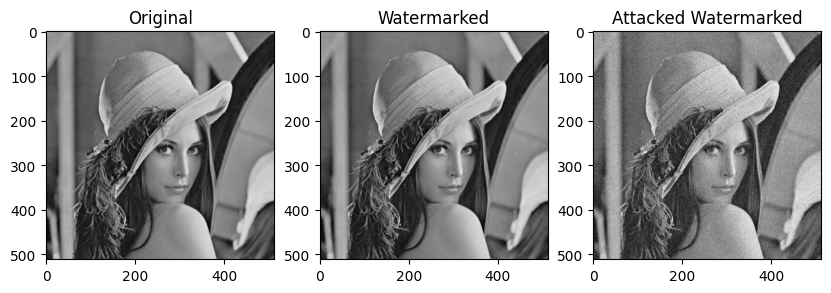

In [4]:
#4

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    #locations = np.argsort(ori_dct,axis=None) # - sign is used to get descending order

    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    start_idx = 10000 #play with this index
    for idx, loc in enumerate(locations[start_idx:mark_size+start_idx]):
    #for idx, loc in enumerate(locations[10000:10000+mark_size]):

    #for idx, (loc,mark_val) in enumerate(zip(locations[1000:1000+mark_size], mark)):

        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return (w_ex)

def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    #locations = np.argsort(ori_dct,axis=None) # - sign is used to get descending order

    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates
    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    start_idx = 10000 #play with this index
    for idx, (loc,mark_val) in enumerate(zip(locations[start_idx:], mark)):

        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)
    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

    return mark, watermarked

plt.figure(figsize=(10, 10))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 15, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity((w_ex),(w_ex_att))
sim_NOTattacked = similarity(mark,(w_ex))
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')



WPSNR non-ATTACKED IMAGE =  62.78562248513153
WPSNR ATTACKED IMAGE =  39.7389669856196
Threshold:  0.7048809930600858


Mark has been found in the non-attacked image. SIM = 1.000000
Mark has been lost in the attacked image. SIM = 0.667014
--------------------------




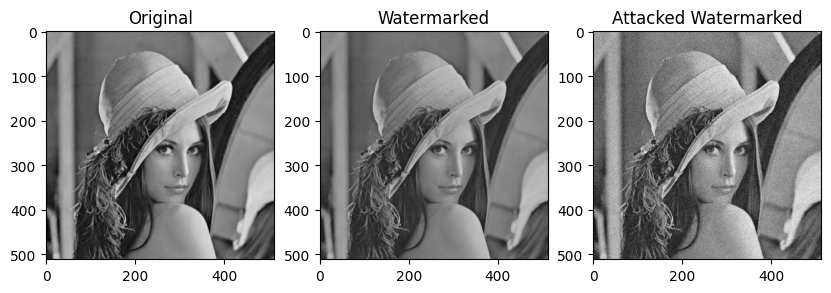

In [7]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(10, 10))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.5
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 15, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


# ROC

To find a better threshold estimation, **do not use just one single image**. Adapt the code of the ROC using the Spread Spectrum to compute the scores on different images (i.e. Lena, Baboon, etc.)

## Get new images

Download new images for your experiments from this [link](https://drive.google.com/file/d/1-n9bmQFDBShRN4Tr_WpmCf1jFHOS5MTO/view?usp=drive_link)

In [6]:
##YOUR CODE

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.fft import dct, idct


import random

def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  from scipy.ndimage.filters import gaussian_filter
  attacked = gaussian_filter(img, sigma)
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  from skimage.transform import rescale
  x, y = img.shape
  attacked = rescale(img, scale)
  attacked = rescale(attacked, 1/scale)
  attacked = attacked[:x, :y]
  return attacked

def jpeg_compression(img, QF):
  from PIL import Image
  img = Image.fromarray(img)
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

def random_attack(img):
  i = random.randint(1,7)
  if i==1:
    attacked = awgn(img, 3., 123)
  elif i==2:
    attacked = blur(img, [3, 3])
  elif i==3:
    attacked = sharpening(img, 1, 1)
  elif i==4:
    attacked = median(img, [3, 3])
  elif i==5:
    attacked = resizing(img, 0.8)
  elif i==6:
    attacked = jpeg_compression(img, 75)
  elif i ==7:
     attacked = img
  return attacked

In [ ]:
import glob

#some parameters for the spread spectrum
mark_size = 1024
alpha = 0.1
v = 'multiplicative'
np.random.seed(seed=124)


#scores and labels are two lists we will use to append the values of similarity and their labels
#In scores we will append the similarity between our watermarked image and the attacked one,
# or  between the attacked watermark and a random watermark
#In labels we will append the 1 if the scores was computed between the watermarked image and the attacked one,
#and 0 otherwise
scores = []
labels = []

images = sorted(glob.glob('path/to/folder/imgs/*.bmp'))

for im in images:
    image = cv2.imread(img_path, 0)

    #Embed Watermark
    mark, watermarked = embedding(image, mark_size, alpha, v)
    sample = 0
    while sample<10:
        #fakemark is the watermark for H0
        fakemark = np.random.uniform(0.0, 1.0, mark_size)
        fakemark = np.uint8(np.rint(fakemark))
        #random attack to watermarked image
        res_att = random_attack(watermarked)
        #extract attacked watermark
        wat_attacked = detection(im, res_att, alpha, mark_size, v)
        wat_extracted = detection(im, watermarked, alpha, mark_size, v)
        #compute similarity H1
        scores.append(similarity(wat_extracted, wat_attacked))
        labels.append(1)
        #compute similarity H0
        scores.append(similarity(fakemark, wat_attacked))
        labels.append(0)
        sample += 1

print('scores array: ', scores)
print('labels array: ', labels)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

#compute ROC
fpr, tpr, tau = roc_curve(np.asarray(labels), np.asarray(scores), drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
idx_tpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])